In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

import sys
sys.path.append("../../")

import nrv

Text(0.5, 1.0, 'Orignal image')

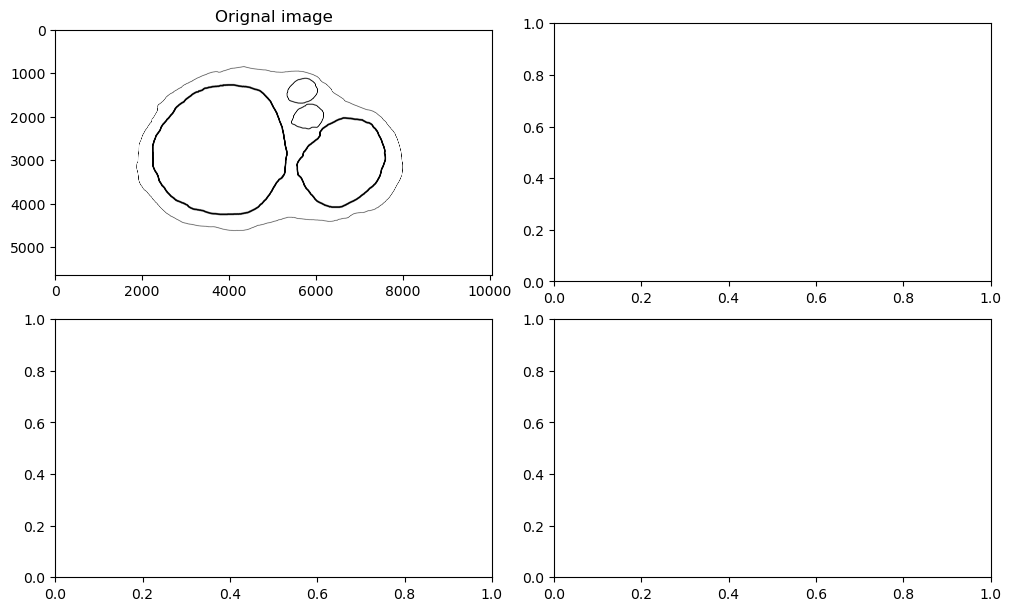

In [2]:
image_path = nrv.__path__[0] + "/_misc/geom/smoothed_edges_white.png"
d_nerve = 1_000 # um
l_nerve = 10_000 # um

im = cv2.imread(image_path)                  #load


fig, axs = plt.subplots(2, 2, figsize=(10,6), layout="constrained")

imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
axs[0,0].imshow(im, label="image")
axs[0,0].set_title("Orignal image")
# axs[0,0].set_axis_off()
# axs[1,0].set_axis_off()
# axs[0,1].set_axis_off()
# axs[1,1].set_axis_off()


(2447, 2)
(827, 2)
(3343, 2)
(827, 2)


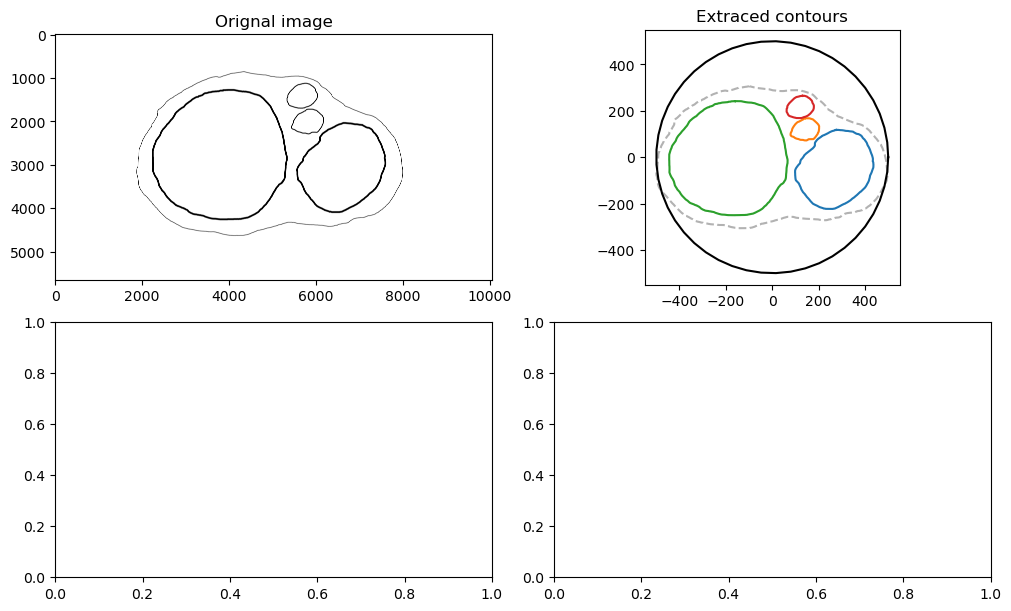

In [3]:
# detect the contours on the binary image using cv2.ChAIN_APPROX_SIMPLE
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hc_list = hierarchy.squeeze()

# ID of the inner nerve coutour
# as image frame is 0, outer_nerve is 1
nerve_id = 2 

# Center nerve to (0,0)
points = contours[nerve_id].squeeze()
center_pix = np.mean(points, axis=0)
nerve_points = points-center_pix

# Convert pixel index to um
radius_pix = np.max(np.abs(nerve_points))
rescal_factor = d_nerve/(2*radius_pix)
# Flip ordinate axis (as pixel index rises downward)
rescal_factor *= np.array([1, -1])

nerve_points *= rescal_factor


axs[0,1].plot(*nerve_points.T, "--",color=("k", .3))

theta = np.linspace(0,2*np.pi)
axs[0,1].plot(d_nerve*np.cos(theta)/2, d_nerve*np.sin(theta)/2, color="k")

fascicles_points = []
for _i, _c in enumerate(contours):
    if hc_list[_i,-1] == nerve_id:
        points = _c.squeeze()
        fascicles_points += [(points-center_pix)*rescal_factor]
        print(fascicles_points[-1].shape)

        axs[0,1].plot(*fascicles_points[-1].T)
axs[0,1].set_aspect("equal")
axs[0,1].set_title("Extraced contours")
fig

Output()

NRV INFO: On 100 axons to generate, there are 30 Myelinated and 70 Unmyelinated


Output()

NRV INFO: On 100 axons to generate, there are 30 Myelinated and 70 Unmyelinated


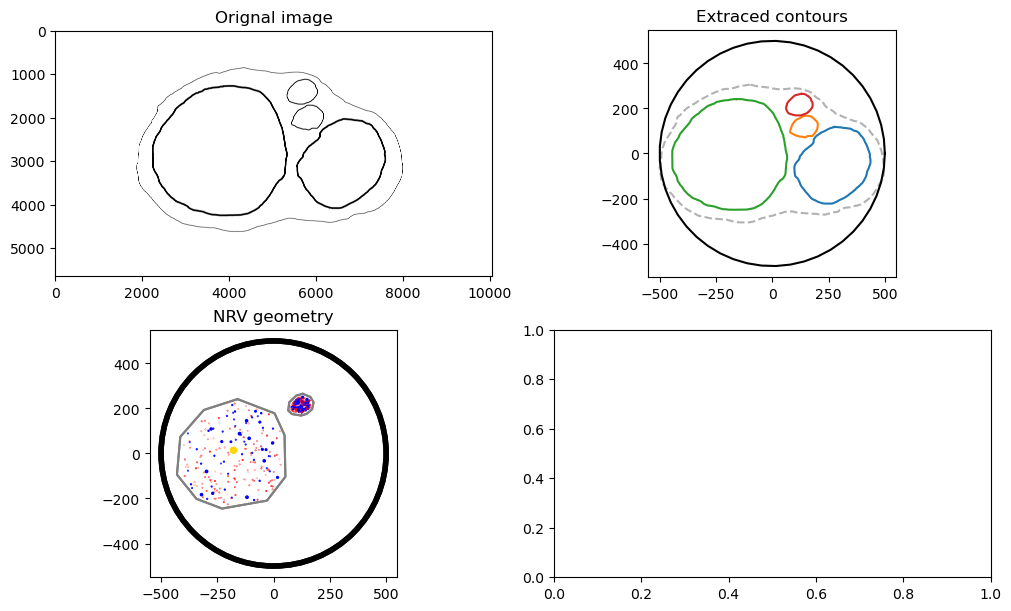

In [6]:
ner = nrv.nerve(diameter=d_nerve, length=l_nerve)
n_vertices = 10
for _i_fasc, _pts in enumerate(fascicles_points[2:]):
    i_pts = np.arange(n_vertices+1)*_pts.shape[0]//n_vertices
    i_pts[-1] -= 1
    _us_pts = _pts[i_pts]  #under sampled the vertices
    poly_fasc = nrv.create_cshape(vertices=_us_pts)
    fasc = nrv.fascicle(ID=str(_i_fasc))
    fasc.set_geometry(geometry=poly_fasc)
    ner.add_fascicle(fasc)


for fasc in ner.fascicles.values():
    fasc.fill(n_ax=100, delta_trace=10)


extra_stim = nrv.FEM_stimulation(endo_mat="endoneurium_ranck",peri_mat="perineurium", epi_mat="epineurium", ext_mat="saline")

life_d = 25                                 #LIFE diamter in um
life_length = 1000                          #LIFE active-site length in um
life_x_offset = (l_nerve-life_length)/2     #x position of the LIFE (centered)
life_y_c_2 , life_z_c_2 = ner.fascicles["0"].center                        #LIFE_2 y-coordinate (in um)


elec_2 = nrv.LIFE_electrode("LIFE_2", life_d, life_length, life_x_offset, life_y_c_2+2, life_z_c_2) # LIFE in the fascicle 2

# stimulus
t_start = 0.1       #start of the pulse, in ms
t_pulse = 0.1       #duration of the pulse, in ms
amp_pulse = 60      #amplitude of the pulse, in uA 

pulse_stim = nrv.stimulus()
pulse_stim.pulse(t_start, -amp_pulse, t_pulse)      #cathodic

#Attach electrodes to the extra_stim object 
extra_stim.add_electrode(elec_2, pulse_stim)
ner.attach_extracellular_stimulation(extra_stim)


ner.plot(axs[1,0])
axs[1,0].set_title("NRV geometry")
fig





In [7]:
res = ner.simulate(postproc_script="is_recruited")


NRV INFO: Starting nerve simulation
NRV INFO: ...computing electrodes footprint
NRV ERROR: One or several domain not found, please check your geometry saved in `./__mesh_geom_dbg.brep`


TypeError: One or several domain not found, please check your geometry saved in `./__mesh_geom_dbg.brep`